In [1]:
# Libraries for numerical operations and data manipulation
import numpy as np                      # For numerical operations and array handling
import pandas as pd                    # For data manipulation and analysis using DataFrames

# Libraries for data visualization
import matplotlib.pyplot as plt        # For creating static plots
import seaborn as sns                  # For creating attractive and informative statistical graphics

# Library for suppressing warning messages
import warnings                        # To manage warning messages in the output
warnings.filterwarnings("ignore")     # Ignore all warning messages for cleaner output

# Scikit-learn utilities for preprocessing and model evaluation
from sklearn.preprocessing import StandardScaler       # For feature scaling (standardization)
from sklearn.model_selection import train_test_split   # For splitting data into training and test sets
from sklearn.utils.class_weight import compute_class_weight  # To handle class imbalance by computing class weights

# TensorFlow and Keras for building and training neural networks
import tensorflow as tf                               # Core TensorFlow library
from tensorflow.keras.models import Sequential         # For building sequential neural network models
from tensorflow.keras.layers import Dense, Dropout     # For adding dense (fully connected) and dropout layers

**DATA CLEANING/DATA PREPROCESSING/EDA**

In [3]:
#Data importation
train = pd.read_csv("/content/customer_churn_dataset-training-master.csv")
# Drop CustomerID column
train = train.drop(columns=["CustomerID"])
#Viewing the first five rows of the train
train.head()

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [4]:
#Check the data type of the train customer dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Age                440832 non-null  float64
 1   Gender             440832 non-null  object 
 2   Tenure             440832 non-null  float64
 3   Usage Frequency    440832 non-null  float64
 4   Support Calls      440832 non-null  float64
 5   Payment Delay      440832 non-null  float64
 6   Subscription Type  440832 non-null  object 
 7   Contract Length    440832 non-null  object 
 8   Total Spend        440832 non-null  float64
 9   Last Interaction   440832 non-null  float64
 10  Churn              440832 non-null  float64
dtypes: float64(8), object(3)
memory usage: 37.0+ MB


In [5]:
#Check the train dataset for missing customer data
train.isnull().sum()

,0
Age,1
Gender,1
Tenure,1
Usage Frequency,1
Support Calls,1
Payment Delay,1
Subscription Type,1
Contract Length,1
Total Spend,1
Last Interaction,1


In [6]:
#Missing value handling strategy
#Continous features are filled using their respective median value
continuous_cols = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction']
# === Fill continuous columns with median ===
for col in continuous_cols:
    median_val = train[col].median()
    train[col].fillna(median_val, inplace=True)
#Categorical features are filled using their respective modal values
# Define column groups
categorical_cols = ['Gender', 'Subscription Type', 'Contract Length', 'Churn']
# Fill categorical columns with mode
for col in categorical_cols:
    train[col] = train[col].fillna(train[col].mode()[0])
# Final check
print("Missing values remaining:\n", train.isnull().sum())

Missing values remaining:
 Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64


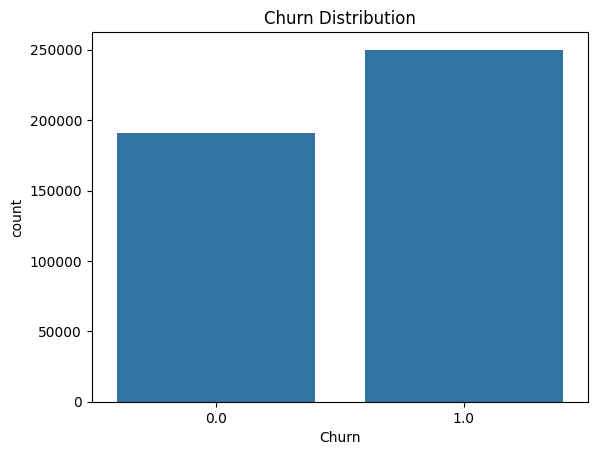

In [7]:
#Check Class Imbalance (Churn Distribution)
sns.countplot(data=train, x='Churn')
plt.title('Churn Distribution')
plt.show()

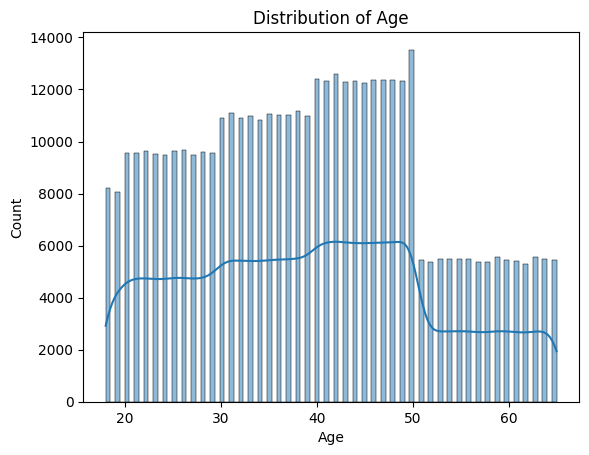

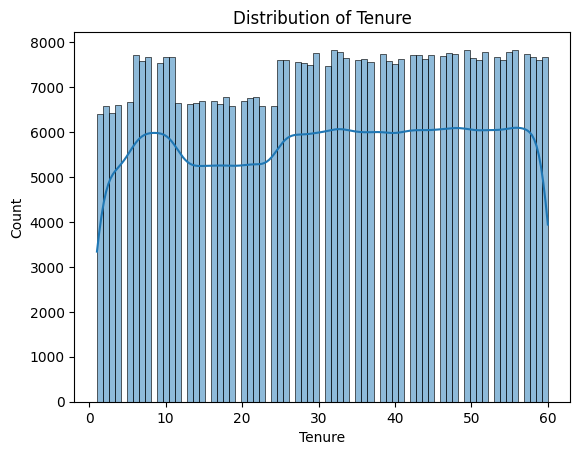

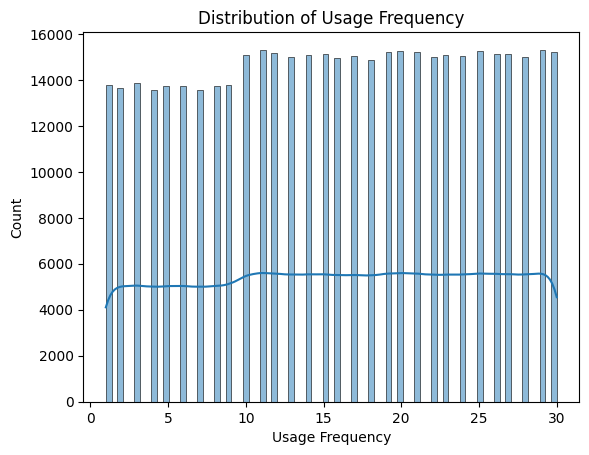

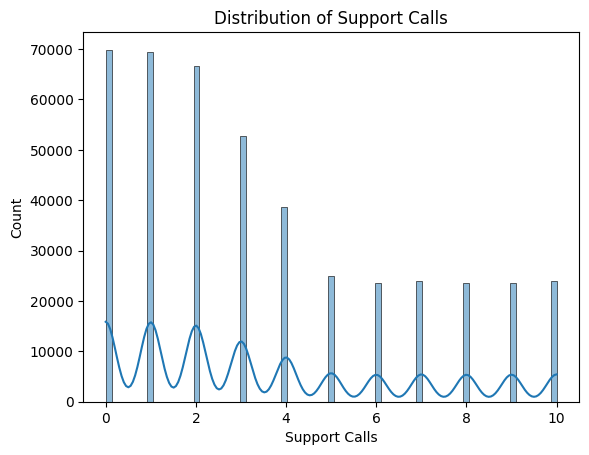

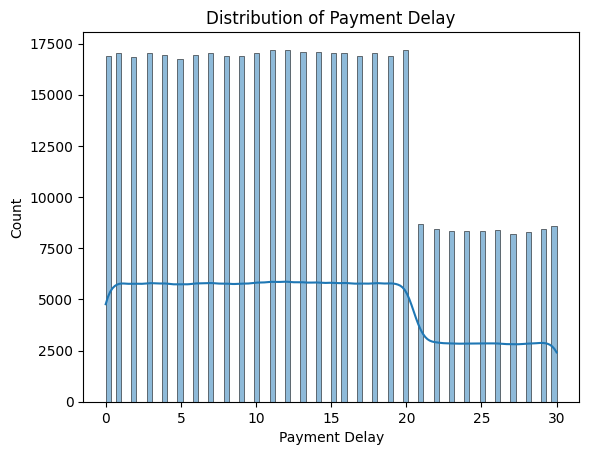

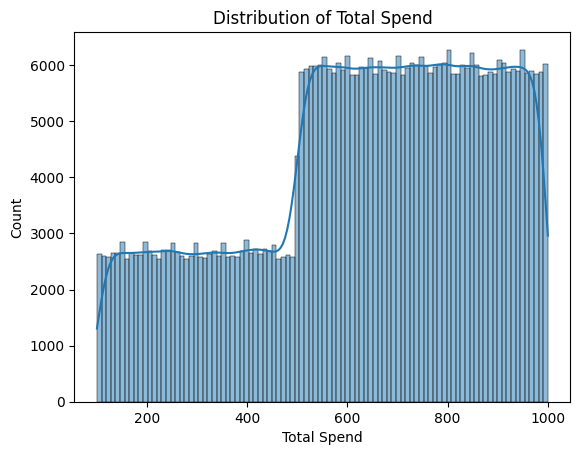

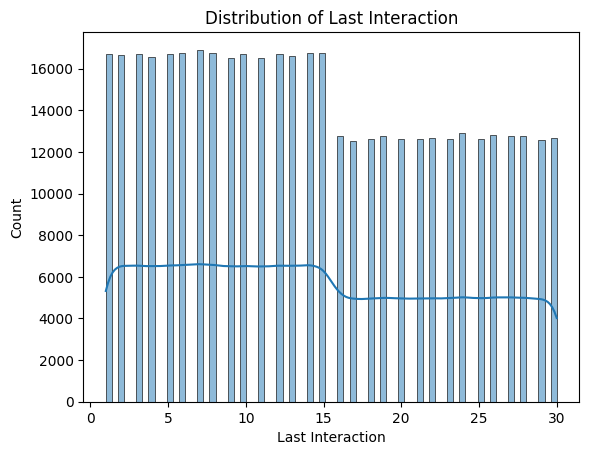

In [8]:
#Distribution Plots for Continuous Features
for col in continuous_cols:
    sns.histplot(train[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

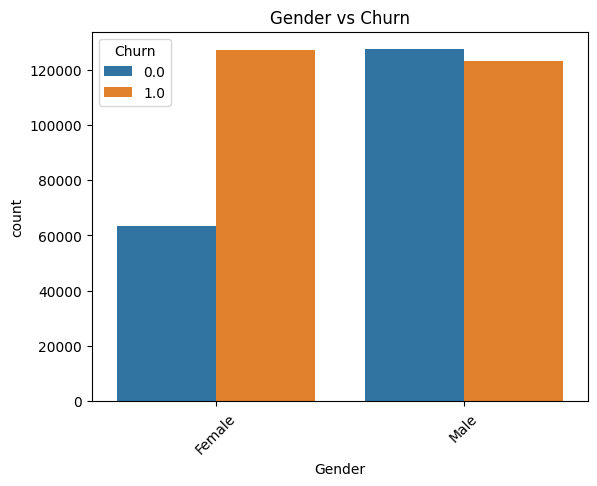

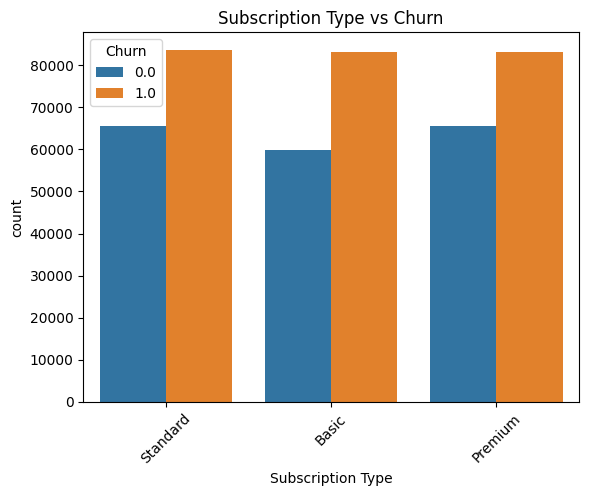

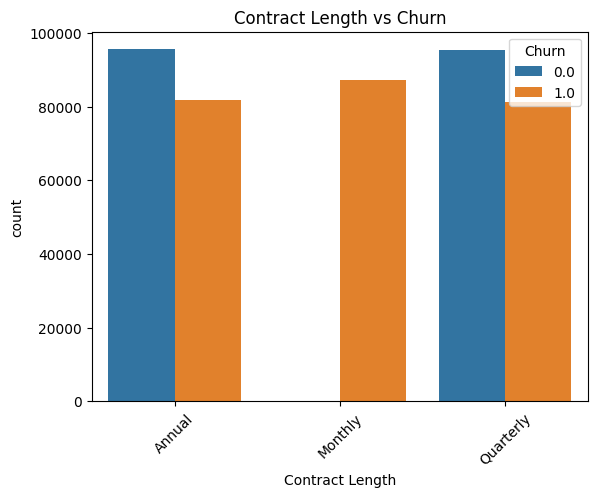

In [9]:
#Categorical features impact on the target variable (Churn)
categorical_cols = ['Gender', 'Subscription Type', 'Contract Length']
for col in categorical_cols:
    sns.countplot(data=train, x=col, hue='Churn')
    plt.title(f'{col} vs Churn')
    plt.xticks(rotation=45)
    plt.show()

In [10]:
# encoders and scalers
gender_map = {'Male': 1, 'Female': 0}
subscription_map = {'Basic': 0, 'Standard': 1, 'Premium': 2}
contract_map = {'Monthly': 0, 'Quarterly': 1, 'Annual': 2}
# Encode categorical columns
train['Gender'] = train['Gender'].map(gender_map)
train['Subscription Type'] = train['Subscription Type'].map(subscription_map)
train['Contract Length'] = train['Contract Length'].map(contract_map)

In [11]:
#View the dataset
train.head()

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,30.0,0,39.0,14.0,5.0,18.0,1,2,932.0,17.0,1.0
1,65.0,0,49.0,1.0,10.0,8.0,0,0,557.0,6.0,1.0
2,55.0,0,14.0,4.0,6.0,18.0,0,1,185.0,3.0,1.0
3,58.0,1,38.0,21.0,7.0,7.0,1,0,396.0,29.0,1.0
4,23.0,1,32.0,20.0,5.0,8.0,0,0,617.0,20.0,1.0


In [12]:
# Initialize an empty list to store churn summary for each categorical feature
summary = []
# Loop through each categorical column to compute churn statistics
for col in categorical_cols:
    # Group data by the current feature and Churn, count the occurrences,
    # and reshape so that Churn values (0 and 1) become columns
    counts = train.groupby([col, 'Churn']).size().unstack(fill_value=0)
    # Calculate total number of customers who did not churn (Churn = 0)
    total_churn_0 = counts[0].sum()
    # Calculate total number of customers who did churn (Churn = 1)
    total_churn_1 = counts[1].sum()
    # Compute the total number of customers for the current feature
    total = total_churn_0 + total_churn_1
    # Calculate churn percentage for the feature
    churn_pct = (total_churn_1 / total * 100).round(1)
    # Append the summarized results as a dictionary to the summary list
    summary.append({
        'Feature': col,
        'Churn = 0 (No)': total_churn_0,
        'Churn = 1 (Yes)': total_churn_1,
        'Total': total,
        '% Churn': churn_pct
    })
# Convert the summary list into a DataFrame for easy viewing and reporting
final_df = pd.DataFrame(summary)
# Display the final summary table
print(final_df)

             Feature  Churn = 0 (No)  Churn = 1 (Yes)   Total  % Churn
0             Gender          190833           250000  440833     56.7
1  Subscription Type          190833           250000  440833     56.7
2    Contract Length          190833           250000  440833     56.7


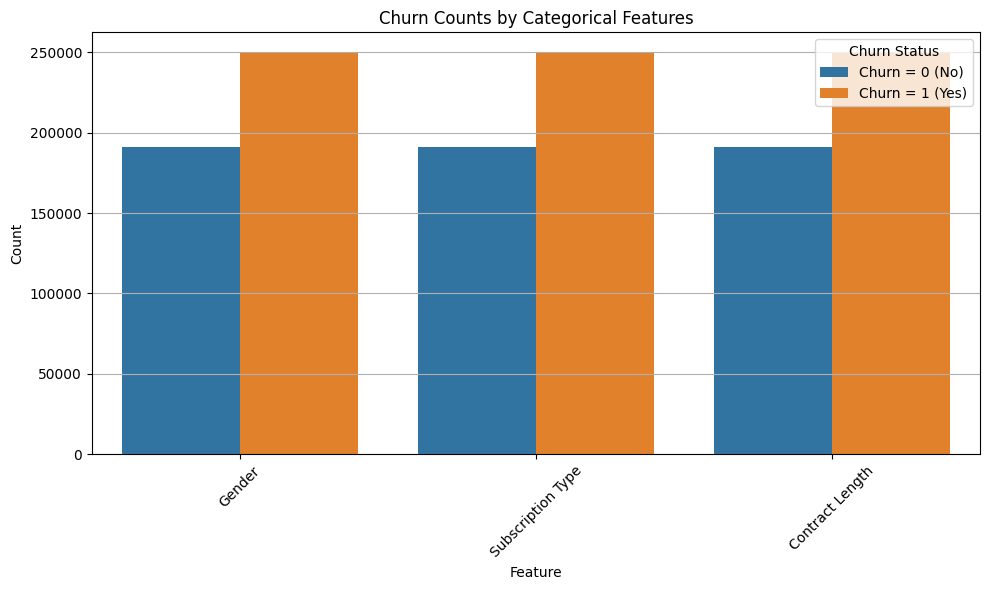

In [13]:
# Melt the summary dataframe so that churn counts become long-form data suitable for seaborn barplot
melted_df = final_df.melt(
    id_vars='Feature',                             # Keep 'Feature' column as identifier
    value_vars=['Churn = 0 (No)', 'Churn = 1 (Yes)'],  # Columns to unpivot (melt)
    var_name='Churn Status',                       # Name for the new column holding original column names
    value_name='Count'                             # Name for the new column holding values
)
# Set up the figure size for the plot
plt.figure(figsize=(10, 6))
# Create a bar plot showing churn counts by feature and churn status
sns.barplot(data=melted_df, x='Feature', y='Count', hue='Churn Status')
# Set the title of the plot
plt.title('Churn Counts by Categorical Features')
# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
# Adjust layout to prevent clipping
plt.tight_layout()
# Add horizontal grid lines to the y-axis
plt.grid(axis='y')
# Display the plot
plt.show()

In [14]:
# Churn rate by Gender
gender_churn = train.groupby('Gender')['Churn'].value_counts(normalize=True).unstack().round(2) * 100
print(gender_churn)
# Churn rate by Subscription Type
subscription_churn = train.groupby('Subscription Type')['Churn'].value_counts(normalize=True).unstack().round(2) * 100
print(subscription_churn)

# Churn rate by Contract Length
contract_churn = train.groupby('Contract Length')['Churn'].value_counts(normalize=True).unstack().round(2) * 100
print(contract_churn)

Churn    0.0   1.0
Gender            
0       33.0  67.0
1       51.0  49.0
Churn               0.0   1.0
Subscription Type            
0                  42.0  58.0
1                  44.0  56.0
2                  44.0  56.0
Churn             0.0    1.0
Contract Length             
0                 NaN  100.0
1                54.0   46.0
2                54.0   46.0


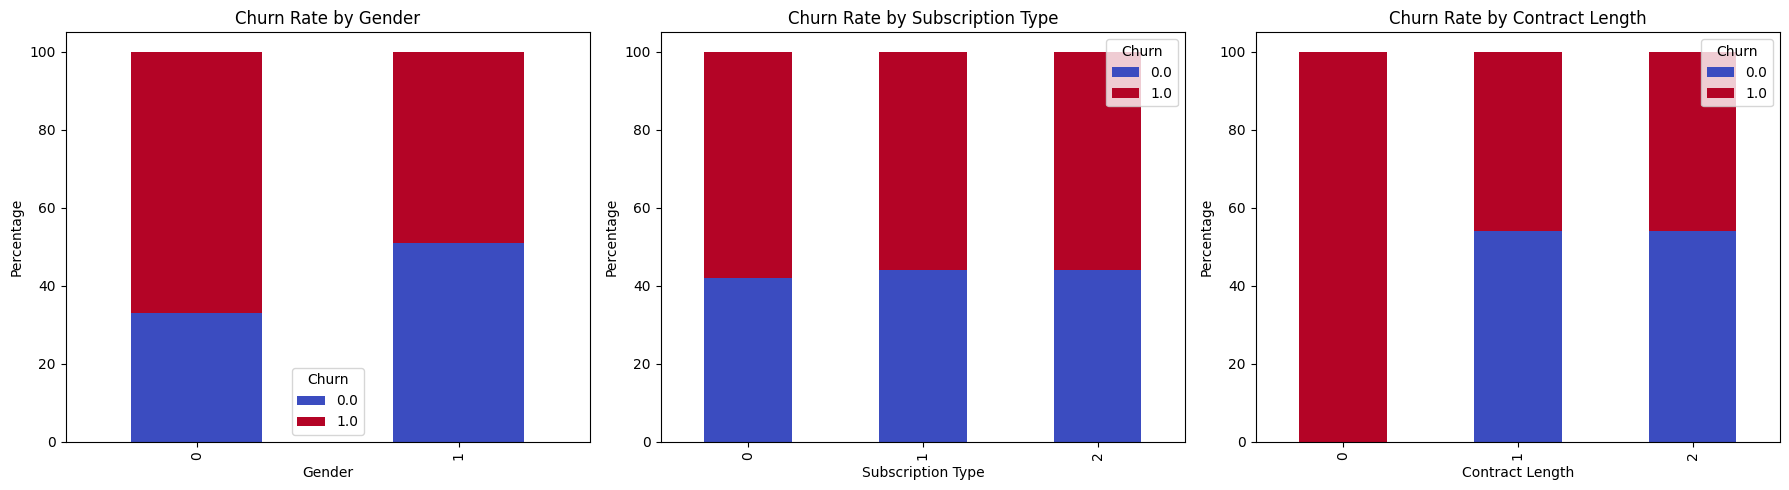

In [15]:
# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# Gender Churn Plot
gender_churn.plot(kind='bar', stacked=True, ax=axes[0], colormap='coolwarm')
axes[0].set_title('Churn Rate by Gender')
axes[0].set_ylabel('Percentage')
axes[0].legend(title='Churn')
# Subscription Type Churn Plot
subscription_churn.plot(kind='bar', stacked=True, ax=axes[1], colormap='coolwarm')
axes[1].set_title('Churn Rate by Subscription Type')
axes[1].set_ylabel('Percentage')
axes[1].legend(title='Churn')
# Contract Length Churn Plot
contract_churn.plot(kind='bar', stacked=True, ax=axes[2], colormap='coolwarm')
axes[2].set_title('Churn Rate by Contract Length')
axes[2].set_ylabel('Percentage')
axes[2].legend(title='Churn')
plt.tight_layout()
plt.show()

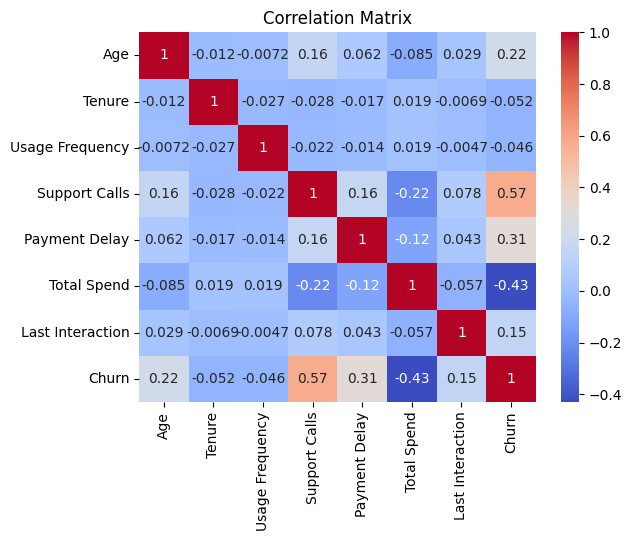

In [16]:
# Compute the correlation matrix for continuous features along with the target variable 'Churn'
corr = train[continuous_cols + ['Churn']].corr()

# Plot a heatmap of the correlation matrix with annotated correlation coefficients
sns.heatmap(corr,
            annot=True,        # Display correlation values inside the heatmap
            cmap='coolwarm')   # Use a diverging color palette for better contrast
# Add a title to the heatmap
plt.title('Correlation Matrix')
# Display the heatmap
plt.show()

In [17]:
train.head()

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,30.0,0,39.0,14.0,5.0,18.0,1,2,932.0,17.0,1.0
1,65.0,0,49.0,1.0,10.0,8.0,0,0,557.0,6.0,1.0
2,55.0,0,14.0,4.0,6.0,18.0,0,1,185.0,3.0,1.0
3,58.0,1,38.0,21.0,7.0,7.0,1,0,396.0,29.0,1.0
4,23.0,1,32.0,20.0,5.0,8.0,0,0,617.0,20.0,1.0


In [18]:
# Group by 'classification' and get descriptive stats for continuous columns
summary_stats = train.groupby('Churn')[continuous_cols].describe()
# Extract only the desired statistics (mean, std, min, 25%, 50%, 75%, max)
selected_stats = summary_stats.loc[:, (slice(None), ['mean', 'std', 'min', '25%', '50%', '75%', 'max'])]
# Reshape so that rows are MultiIndex (classification, variable), columns are statistics
# This will make it easier to read or export
summary_clean = selected_stats.stack(level=0)
# Rename index levels for clarity
summary_clean.index.names = ['classification', 'variable']
# Sort by classification and variable
summary_clean = summary_clean.sort_index()
# Show the result
summary_clean

mean         std    min    25%     50%  \
classification variable                                                         
0.0            Age                36.262973    9.203910   18.0   29.0   37.00   
               Last Interaction   13.008804    8.291378    1.0    6.0   12.00   
               Payment Delay      10.015500    6.056744    0.0    5.0   10.00   
               Support Calls       1.586418    1.289975    0.0    0.0    1.00   
               Tenure             32.281754   17.089172    1.0   18.0   33.00   
               Total Spend       749.953111  144.222792  500.0  625.3  749.98   
               Usage Frequency    16.260552    8.446843    1.0   10.0   17.00   
1.0            Age                41.747252   13.975058   18.0   30.0   42.00   
               Last Interaction   15.604540    8.654913    1.0    8.0   16.00   
               Payment Delay      15.217716    8.974065    0.0    7.0   15.00   
               Support Calls       5.144852    3.141636    0.0    2.0    5.00   
               Tenure             30.473604   17.341030    1.0   15.0   30.00   
               Total Spend       541.286006  259.850313  100.0  316.0  534.00   
               Usage Frequency    15.461660    8.675235    1.0    8.0   15.00   

                                    75%     max  
classification variable                          
0.0            Age                44.00    50.0  
               Last Interaction   19.00    30.0  
               Payment Delay      15.00    20.0  
               Support Calls       3.00     5.0  
               Tenure             47.00    60.0  
               Total Spend       874.74  1000.0  
               Usage Frequency    24.00    30.0  
1.0            Age                54.00    65.0  
               Last Interaction   23.00    30.0  
               Payment Delay      23.00    30.0  
               Support Calls       8.00    10.0  
               Tenure             46.00    60.0  
               Total Spend       767.00  1000.0  
               Usage Frequency    23.00    30.0

In [19]:
# Separate features and target
X = train.drop("Churn", axis=1)
y = train["Churn"]
# Normalize continuous features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
# Split the data: 70% train, 15% validation, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)
print(f'Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}')

Train shape: (308572, 10), Val shape: (66136, 10), Test shape: (66125, 10)


In [21]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(1.1550255281558341), 1: np.float64(0.8816645142119158)}


In [22]:
# Build ANN Model
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
# Train the model
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 50, batch_size = 64, class_weight = class_weight_dict, verbose=1)

Epoch 1/50
4822/4822 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9277 - loss: 0.1799 - val_accuracy: 0.9916 - val_loss: 0.0276
Epoch 2/50
4822/4822 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9900 - loss: 0.0320 - val_accuracy: 0.9946 - val_loss: 0.0200
Epoch 3/50
4822/4822 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9941 - loss: 0.0216 - val_accuracy: 0.9960 - val_loss: 0.0160
Epoch 4/50
4822/4822 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9945 - loss: 0.0200 - val_accuracy: 0.9962 - val_loss: 0.0167
Epoch 5/50
4822/4822 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9951 - loss: 0.0182 - val_accuracy: 0.9957 - val_loss: 0.0163
Epoch 6/50
4822/4822 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9949 - loss: 0.0188 - val_accuracy: 0.9960 - val_loss: 0.0150
Epoch 7/50
4822/4822 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9950 - loss: 0.0184 - val_accuracy: 0.9965 - val_loss: 0.0136
Epoch 8/50
4822/4822 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9952 - loss: 0

In [24]:
# Evaluate the model
print("\nTest Evaluation:")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")


Test Evaluation:
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9975 - loss: 0.0068
Test Loss: 0.0069, Test Accuracy: 0.9975


In [25]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [26]:
# Classification Report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

2067/2067 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

Confusion Matrix:
[[28625     0]
 [  163 37337]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     28625
         1.0       1.00      1.00      1.00     37500

    accuracy                           1.00     66125
   macro avg       1.00      1.00      1.00     66125
weighted avg       1.00      1.00      1.00     66125



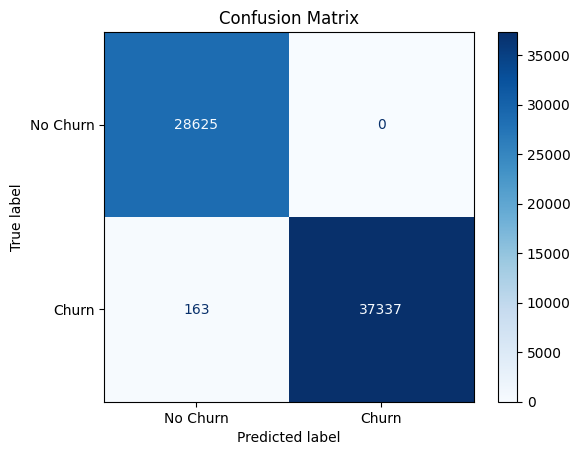

In [27]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [28]:
#Save the model
model.save('ann_churn_model.h5')